# Kalman Filter for Dynamic Systems

In  this Section we'll consider the full implementation of the Kalman filter equations. Differently from the previous implementation, we also consider the effects of known inputs $\mathbf{u}$ in the state evolution model:


--------------------------------------------------------------------------------------------- Prediction ----------------------------------------------------------------------------------
#### $$ \begin{matrix}
\mathbf{x}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{x}_k +  \mathbf{G}_k \mathbf{u}_k + \mathbf{w}_k\\
\mathbf{P}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{P}_{k}^P \mathbf{\Phi}_{t_k}^T + \mathbf{Q}_{k}\end{matrix}$$

---------------------------------------------------------------------------------------------- Update ------------------------------------------------------------------------------------

#### $$ \begin{matrix}
 \mathbf{K}_{k+1}=\mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T\left ( \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P \mathbf{H}_{k+1}^T + \mathbf{R}_{k+1} \right )^{-1} \\
 \mathbf{P}_{k+1}=\mathbf{P}_{k+1}^P - \mathbf{K}_{k+1} \mathbf{H}_{k+1} \mathbf{P}_{k+1}^P \\
 \mathbf{x}_{k+1} = \mathbf{x}_{k+1}^P +\mathbf{K}_{k+1} \left ( \mathbf{y}_{k+1}-\mathbf{H}_{k+1} \mathbf{x}_{k+1}^P\right )
\end{matrix}$$

, where 

#### $$ \mathbf{y}_{k} = \mathbf{H}_{k} \mathbf{x}_{k}+ \mathbf{e}_{k}$$

Here below is reported a summary table containing information on the elements in the Kalman filter equations. $n$ is the number of states, $q$ is the number of measurement types evaluated at each step, $r$ is the number of inputs

| Symbol | Name                            | Dimension             | Type         |
|--------|---------------------------------|-----------------------|--------------|
| **x**  | State vector                    | *n*x*1* column vector | Output       |
| **Φ**  | State transition matrix         | *n*x*n* matrix        | System model |
| **w**  | Process noise                   | *n*x*1* column vector | System model |
| **G**  | Input to state matrix           | *n*x*r* matrix        | System model |
| **u**  | Input vector                    | *r*x*1* column vector | Input        |
| **P**  | State covariance matrix         | *n*x*n* matrix        | Output       |
| **Q**  | Process noise covariance matrix | *n*x*n* matrix        | System model |
| **K**  | Kalman gain                     | *n*x*q* matrix        | Internal     |
| **R**  | Measurements covariance matrix  | *q*x*q* matrix        | Input        |
| **H**  | State to measurement matrix     | *q*x*n* matrix        | System model |
| **y**  | Measurements                    | *q*x*1* column vector | Input        |



Note as $\mathbf{w}$ and $\mathbf{u}$ are gaussian, zero mean random values and uncorrelated to each other.


## Example - Free falling object
In this example we'll consider an object under the effect of the gravity (free falling) starting from an unknown height $x_0$ with a positive initial speed $v_0$ directed along $x$ (one-dimensional problem):

<center><img src="Images/freeFallKf.png" alt="Drawing" style="width: 200px;"/><center>


We are interested in estimating the position and the velocity of the body, so the state vector ($n$x$1$ column vector) in this case is 

  
#### $$ \mathbf{x} = \begin{bmatrix}
pos \\
vel
\end{bmatrix} $$

The system is observed by a tracking device placed at $x$=0 that measures the distance with the falling body. It follows that the state to measurement matrix $\mathbf{H}$, which relates the state vector with the measurement vector is:

#### $$ \mathbf{H} = \begin{bmatrix}
1 &
0
\end{bmatrix} $$

#### $$ \mathbf{y}_{k} = \begin{bmatrix}
1 &
0
\end{bmatrix} \begin{bmatrix}
pos_{k} \\
vel_{k}
\end{bmatrix}+ \mathbf{e}_{k} = pos_{k} + e_k$$


The measurement covariance matrix $\mathbf{R}$ accounts for uncertainty of the measurment device. In this case it is a scalar value, since we only have one measurement type available

#### $$ \mathbf{R} = \sigma_{meas}^2$$

The differential equation which describes the position of the body along the $x$ axis is:
    
#### $$ x(t)=x_{0} + v_{0}* t - \frac{1}{2}*g*t^{2}  $$

The prediction equation is written as (we don't consider $\mathbf{w}_k$ in this example:

#### $$\mathbf{x}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{x}_k +  \mathbf{G}_k \mathbf{u}_k  $$

which, in this case is written as

#### $$ \begin{bmatrix}
pos_{k+1} \\
vel_{k+1}
\end{bmatrix}= \begin{bmatrix}
1 &  \Delta t\\
0 &  1\\
\end{bmatrix}\begin{bmatrix}
pos_{k} \\
vel_{k}
\end{bmatrix} - g \begin{bmatrix}
0 \\
\Delta t
\end{bmatrix}$$



In [1]:
from estimation import *
%matplotlib widget

###### system model (truth) #######
initialPos = 110  # m
initialVel = 15  # m/sec
###################################

########## meas model #############
sigmaMeas    = 1   # m - 1-sigma uncertainty of the measuring device
nMeasurements = 40
timeStep      = 0.1 # sec - time between measurements
###################################


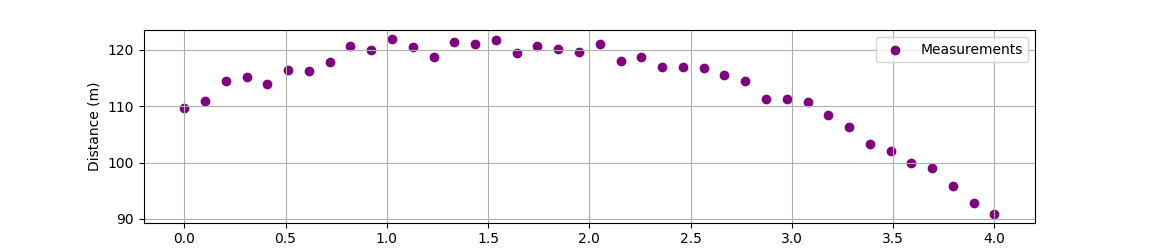

In [2]:

# measurement set generation
measTimes = np.linspace(timeStep, nMeasurements*timeStep, nMeasurements)
truePosition = np.empty(nMeasurements)
trueVelocity = np.empty(nMeasurements)
measurements = np.empty(nMeasurements)
for i in range (0, nMeasurements):
 truePosition[i] = (initialPos + initialVel*measTimes[i] -0.5*9.81*measTimes[i]*measTimes[i])
 trueVelocity[i] = initialVel - 9.81*measTimes[i]
 measurements[i] = + truePosition[i] + sigmaMeas * np.random.randn()

# plot
e = plt.figure(figsize=(11.5,2.5))
plt.scatter(np.linspace(0, nMeasurements*timeStep, nMeasurements), measurements, color = 'purple', label='Measurements',  marker='o')
plt.legend()
plt.ylabel('Distance (m)')
plt.xlabel('Time (sec)')
plt.grid(True)
plt.show()

In Kalman filter the estimte of the state comes with some uncertainty, highlighting how much we can trust the estimate itself. The state covariance matrix provides the probability distribution of the estimate:



####  $$ \mathbf{P} = \begin{bmatrix}
\sigma_{pos}^2 &  \sigma_{pos}\sigma_{vel}\\
\sigma_{pos}\sigma_{vel} &  \sigma_{vel}^2\\
\end{bmatrix} $$

$\mathbf{P}$ accounts for modelling errors, representing the uncertainty in the system prediction model. It evolves over time as function of the state transition matrix and the process noise covariance matrix $\mathbf{Q}$. 
The way how $\mathbf{Q}$ is chosen is complex. In practice, it is often chosen as a simple diagonal matrix and its elements are determined by trial and error. Although this method can be effective for a particular estimation scenario, such a process noise matrix is not generally applicable to other scenarios. The dynamic evolution of the true states of parameters estimated in a filter typically is affected by stochastic processes that are not
modeled in the filte r’s deterministic dynamic model. The process noise model is a characterization of these stochastic processes, and the process noise covariance matrix should be determined by this process noise model.

For this example we define

####  $$ \mathbf{Q} = s_d \begin{bmatrix}
\frac{\Delta t^3}{3} &  0\\
0 &  \Delta t\\
\end{bmatrix} $$

Where $s_d$ is the **spectral density**, the scalar variable that can be tuned to add or remove process noise from the system model. The prediction equation for the state covariance matrix is

#### $$ \mathbf{P}_{k+1}^P=\mathbf{\Phi}_{t_k} \mathbf{P}_{k}^P \mathbf{\Phi}_{t_k}^T + \mathbf{Q}_{k}= \begin{bmatrix}
1 &  \Delta t\\
0 &  1\\
\end{bmatrix} \begin{bmatrix}
\sigma_{pos}^2 &  \sigma_{pos}\sigma_{vel}\\
\sigma_{pos}\sigma_{vel} &  \sigma_{vel}^2\\
\end{bmatrix} \begin{bmatrix}
1 &  0\\
\Delta t &  1\\
\end{bmatrix} + s_d \begin{bmatrix}
\frac{\Delta t^3}{3} &  0\\
0 &  \Delta t\\
\end{bmatrix}  $$

The code below defines the state estimate and its uncertainties:

In [3]:

######### state estimate ##########
estimatedPos   = 130    # m
estimatedVel   = 10    # m/sec
###################################

########## uncertainties ##########
sigmaPos = 10  # m - 1-sigma uncertainty of the initial position
sigmaVel = 3  # m/sec - 1-sigma uncertainty of the initial velocity
sp             = 0.5 # spectral density
###################################

The filter has to be initialized before running the estimation process:

In [4]:
# filter initialization
def filter():
    # state transition matrix
    filter.A = np.array([[1, timeStep],
                         [0, 1]])
    # input vector
    filter.U = -9.81 * np.array([[0],
                                 [timeStep]])
    # state
    filter.x = np.array([[estimatedPos],
                         [estimatedVel]])
    # state covariance matrix
    filter.P = np.array([[sigmaPos* sigmaPos, 0],
                         [0, sigmaVel * sigmaVel]])
    # state to measurement matrix
    filter.H = np.array([[1, 0]])
    # measure covariance matrix
    filter.R = sigmaMeas * sigmaMeas
    # process noise covariance matrix

    filter.Q = sp * np.array([[math.pow(timeStep,3)/3, 0.0],
                              [0.0, timeStep]])
    return filter

res = filter()

After initialization, the filter can start the estimation process, which happens anytime a new measurement is available:

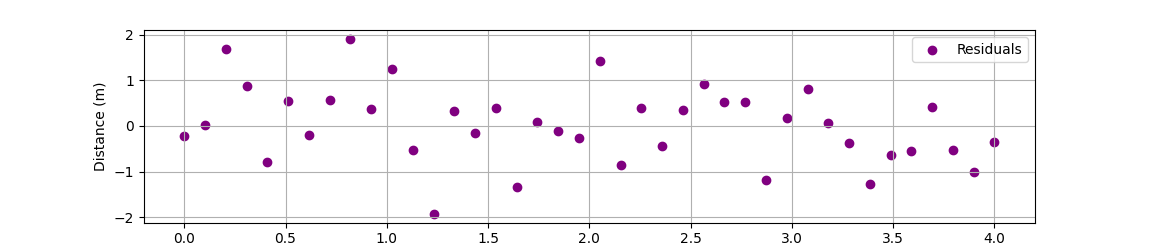

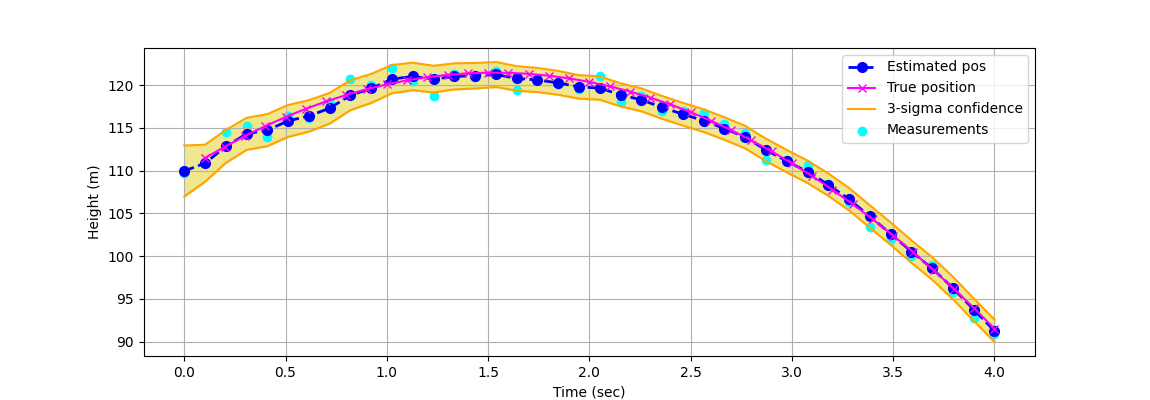

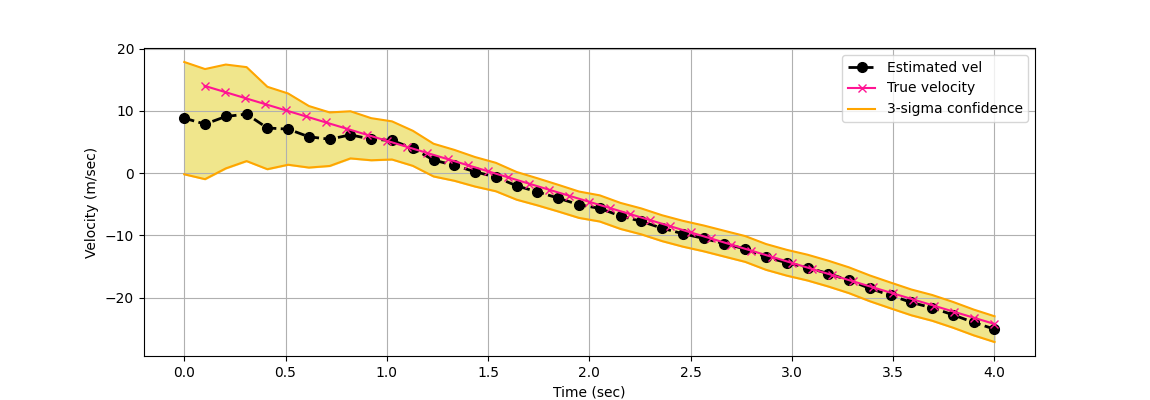

In [5]:
def process(y, filter):
    ####### Predict ########
    # State
    x_p = filter.A.dot(filter.x) + filter.U
    # Covariance
    P_p = filter.A.dot(filter.P).dot(filter.A.T) + filter.Q

    ####### Update ########
    # Compute Kalman Gain
    S = filter.H.dot(P_p).dot(np.transpose(filter.H)) + filter.R
    K = P_p.dot(np.transpose(filter.H))*(1/S)
    # Estimate State
    residual = y - filter.H.dot(x_p)
    filter.x = x_p + K*residual
    # Estimate Covariance
    filter.P = P_p - K.dot(filter.H).dot(P_p)
    return [filter.x, filter.P, residual]

# arrays definition
posEstimates     = []
posUncertainties = []
velEstimates     = []
velUncertainties = []
residuals        = []
highPosConfidenceEnd = []
lowPosConfidenceEnd  = []
highVelConfidenceEnd = []
lowVelConfidenceEnd  = []

# process measurements
for i in range (0, nMeasurements):
    res = process(measurements[i], filter)
    posEstimates.append(res[0][0].reshape(()))
    posUncertainties.append(math.sqrt(res[1][0][0]))
    velEstimates.append(res[0][1].reshape(()))
    velUncertainties.append(math.sqrt(res[1][1][1]))
    highPosConfidenceEnd.append(posEstimates[i] + 3 * posUncertainties[i])
    lowPosConfidenceEnd.append(posEstimates[i] - 3 * posUncertainties[i])
    highVelConfidenceEnd.append(velEstimates[i] + 3 * velUncertainties[i])
    lowVelConfidenceEnd.append(velEstimates[i] - 3 * velUncertainties[i])


# plot outputs
h = plt.figure(figsize=(11.5,2.5))
plt.scatter(np.linspace(0, nMeasurements*timeStep, nMeasurements), measurements - posEstimates, color = 'purple', label='Residuals',  marker='o')
plt.legend()
plt.ylabel('Distance (m)')
plt.xlabel('Time (sec)')
plt.grid(True)
plt.show()

f = plt.figure(figsize=(11.5,4))
plt.plot(np.linspace(0, nMeasurements*timeStep, nMeasurements), posEstimates, color='blue', linewidth=2, label='Estimated pos', linestyle='--', marker='o', markersize=7)
plt.plot(np.linspace(timeStep, nMeasurements*timeStep, nMeasurements), truePosition, color='fuchsia', marker='x',label='True position')
plt.plot(np.linspace(0, nMeasurements*timeStep, nMeasurements), lowPosConfidenceEnd, color='orange', label='3-sigma confidence')
plt.plot(np.linspace(0, nMeasurements*timeStep, nMeasurements), highPosConfidenceEnd, color='orange')
plt.fill_between(np.linspace(0, nMeasurements*timeStep, nMeasurements), lowPosConfidenceEnd, highPosConfidenceEnd, color = 'khaki')
plt.scatter(np.linspace(0, nMeasurements*timeStep, nMeasurements), measurements, color='cyan', label='Measurements')
plt.legend()
plt.ylabel('Height (m)')
plt.xlabel('Time (sec)')
plt.grid(True)
plt.show()


g = plt.figure(figsize=(11.5,4))
plt.plot(np.linspace(0, nMeasurements*timeStep, nMeasurements), velEstimates, color = 'black', linewidth=2, label='Estimated vel', linestyle='--', marker='o', markersize=7)
plt.plot(np.linspace(timeStep, nMeasurements*timeStep, nMeasurements), trueVelocity, color = 'deeppink', marker='x', label='True velocity')
plt.plot(np.linspace(0, nMeasurements*timeStep, nMeasurements), lowVelConfidenceEnd, color='orange', label='3-sigma confidence')
plt.plot(np.linspace(0, nMeasurements*timeStep, nMeasurements), highVelConfidenceEnd, color='orange')
plt.fill_between(np.linspace(0, nMeasurements*timeStep, nMeasurements), lowVelConfidenceEnd, highVelConfidenceEnd, color = 'khaki')
plt.legend()
plt.ylabel('Velocity (m/sec)')
plt.xlabel('Time (sec)')
plt.grid(True)
plt.show()